In [1]:
import os

# to avoid the following error when using MPS (GPU in ARM architecture)):
# NotImplementedError: The operator 'aten::scatter_reduce.two_out'
# is not currently implemented for the MPS device. If you want
# this op to be added in priority during the prototype phase of
# this feature, please comment on
# https://github.com/pytorch/pytorch/issues/77764.
# As a temporary fix, you can set the environment variable
# `PYTORCH_ENABLE_MPS_FALLBACK=1` to use the CPU as
# a fallback for this op.
# WARNING: this will be slower than running natively on MPS.
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"  # before importing torch


\# TODO

- <s>BatchNormalization?</s>
- ハイパーパラメータチューニング (optuna?)
- <s>モデルの解釈 (tanhやpoolingについて)</s>
  - tanh: 活性化関数
  - pooling: すべての原子の情報を統合する。原子数が異なるためそれらを揃える役割も。
- <s>dropoutの導入？←過学習対策</s>
- autumentation?
- モデルの途中保存 (エポック毎?)
- エッジの重みも学習する (`nn.Parameter`?)

In [2]:
import numpy as np
import pandas as pd
import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.axes
from sklearn.ensemble import RandomForestRegressor

import torch
import torch_geometric
import torch_geometric.nn
import torch_geometric.data
import torch_geometric.loader

from src.data import GraphDataset
from src.model import GCN
from src.torch_utils import fit, eval_loss, evaluate_history, torch_seed
from src.utils import yyplot, check_tqdm


In [3]:
torch.__version__


'2.1.0'

In [4]:
torch_geometric.__version__


'2.4.0'

In [5]:
rdkit.__version__


'2023.09.1'

In [6]:
seed = 334
batch_size = 256

torch_seed(seed)


In [7]:
# df_raw = pd.read_csv("./data/curated-solubility-dataset.csv", index_col=0)
df_raw = pd.read_csv("./data/logSdataset1290.csv", index_col=0)
# 計算時間短縮
# df_raw = df_raw.iloc[:1000]
print(df_raw.shape)
df_raw.head()


(1290, 197)


,logS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
CC(N)=O,1.58,59.068,54.028,59.037114,24,0,0.213790,-0.369921,0.369921,0.213790,...,0,0,0,0,0,0,0,0,0,0
CNN,1.34,46.073,40.025,46.053098,20,0,-0.001725,-0.271722,0.271722,0.001725,...,0,0,0,0,0,0,0,0,0,0
CC(=O)O,1.22,60.052,56.020,60.021129,24,0,0.299685,-0.481433,0.481433,0.299685,...,0,0,0,0,0,0,0,0,0,0
C1CCNC1,1.15,71.123,62.051,71.073499,30,0,-0.004845,-0.316731,0.316731,0.004845,...,0,0,0,0,0,0,0,0,0,0
NC(=O)NO,1.12,76.055,72.023,76.027277,30,0,0.335391,-0.349891,0.349891,0.335391,...,0,0,0,0,0,0,0,0,0,1


In [8]:
# smiles = df_raw["SMILES"]
# y = df_raw["Solubility"]
smiles = df_raw.index
y = df_raw["logS"]


In [9]:
# scaling
y_mean = y.mean()
y_std = y.std(ddof=1)


In [10]:
smiles = smiles.tolist()
y = ((y - y_mean) / y_std).tolist()


In [11]:
mols = map(Chem.MolFromSmiles, smiles)


In [12]:
dataset = GraphDataset(mols, y, n_jobs=-1)
dataset


GraphDataset(1290)

In [13]:
# dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
dataloader = torch_geometric.loader.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)
# the following is deprecated
# dataloader = torch_geometric.data.DataLoader(
#     dataset, batch_size=batch_size, shuffle=True
# )
dataloader


In [14]:
dataset_train, dataset_test = train_test_split(
    dataset, test_size=0.2, random_state=seed
)
dataset_train, dataset_val = train_test_split(
    dataset_train, test_size=0.1, random_state=seed
)
print(len(dataset_train), len(dataset_val), len(dataset_test))


928 104 258


In [15]:
dataloader_train = torch_geometric.loader.DataLoader(
    dataset_train, batch_size=batch_size, shuffle=True
)
dataloader_val = torch_geometric.loader.DataLoader(
    dataset_val, batch_size=batch_size, shuffle=False
)
dataloader_test = torch_geometric.loader.DataLoader(
    dataset_test, batch_size=batch_size, shuffle=False
)


In [16]:
data = dataset_train[0]
num_features = data.x.shape[1]


In [17]:
model = GCN(in_channels=num_features, embedding_size=64)
print(model)


GCN(
  (initial_conv): GCNConv(30, 64)
  (batch_norm0): BatchNorm(64)
  (conv1): GCNConv(64, 64)
  (batch_norm1): BatchNorm(64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (dropout): Dropout(p=0.01, inplace=False)
  (relu): LeakyReLU(negative_slope=0.01)
  (out): Linear(in_features=128, out_features=1, bias=True)
)


In [18]:
# Need 'tabulate' package
print(torch_geometric.nn.summary(model, data))


+----------------------------+---------------+----------------+----------+
| Layer                      | Input Shape   | Output Shape   | #Param   |
|----------------------------+---------------+----------------+----------|
| GCN                        | [14, 14]      | [1]            | 14,849   |
| ├─(initial_conv)GCNConv    |               | [14, 64]       | 1,984    |
| ├─(batch_norm0)BatchNorm   | [14, 64]      | [14, 64]       | 128      |
| │    └─(module)BatchNorm1d | [14, 64]      | [14, 64]       | 128      |
| ├─(conv1)GCNConv           |               | [14, 64]       | 4,160    |
| ├─(batch_norm1)BatchNorm   | [14, 64]      | [14, 64]       | 128      |
| │    └─(module)BatchNorm1d | [14, 64]      | [14, 64]       | 128      |
| ├─(conv2)GCNConv           |               | [14, 64]       | 4,160    |
| ├─(conv3)GCNConv           |               | [14, 64]       | 4,160    |
| ├─(dropout)Dropout         | [14, 64]      | [14, 64]       | --       |
| ├─(relu)LeakyReLU      

In [19]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")


In [20]:
history = fit(
    model.to(device),
    optimizer=torch.optim.Adam(model.parameters(), lr=0.002),
    criterion=torch.nn.MSELoss(),
    train_loader=dataloader_train,
    val_loader=dataloader_val,
    # num_epochs=10,
    # num_epochs=100,
    num_epochs=50,
    device=device,
    ipynb=True,
)


  0%|          | 0/4 [00:00<?, ?it/s]

/Users/yu9824/miniforge3/envs/torch39/lib/python3.9/site-packages/torch_geometric/utils/scatter.py:94: UserWarning: The operator 'aten::scatter_reduce.two_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1695391825142/work/aten/src/ATen/mps/MPSFallback.mm:13.)
  return src.new_zeros(size).scatter_reduce_(


Epoch [1/50], loss: 0.90573 val_loss: 1.11024, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.65772 val_loss: 1.07897, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.48013 val_loss: 1.07546, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.35762 val_loss: 0.97763, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.28725 val_loss: 0.91301, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.25616 val_loss: 0.79823, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.22280 val_loss: 0.62139, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.20234 val_loss: 0.55504, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.18109 val_loss: 0.45204, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.16404 val_loss: 0.39689, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.15008 val_loss: 0.30285, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.14098 val_loss: 0.28234, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.13333 val_loss: 0.23334, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.13303 val_loss: 0.23118, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.13136 val_loss: 0.20776, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.13103 val_loss: 0.20392, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.12927 val_loss: 0.19790, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.11058 val_loss: 0.20586, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.11392 val_loss: 0.20852, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.11155 val_loss: 0.18735, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.12452 val_loss: 0.21914, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.12238 val_loss: 0.23738, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.13147 val_loss: 0.24315, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.13969 val_loss: 0.19748, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.12203 val_loss: 0.19781, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.09707 val_loss: 0.19639, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.10588 val_loss: 0.18579, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.10031 val_loss: 0.18474, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.10459 val_loss: 0.18939, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.09546 val_loss: 0.19117, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.09660 val_loss: 0.19203, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.09205 val_loss: 0.18864, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.09362 val_loss: 0.19497, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.09492 val_loss: 0.19074, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.09140 val_loss: 0.18927, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.08859 val_loss: 0.17698, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.07234 val_loss: 0.17452, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.07744 val_loss: 0.18410, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.07795 val_loss: 0.17918, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.08047 val_loss: 0.17930, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.08549 val_loss: 0.19851, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.08780 val_loss: 0.19113, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.08879 val_loss: 0.21513, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.09092 val_loss: 0.22181, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.08719 val_loss: 0.22644, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.09328 val_loss: 0.18003, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.08128 val_loss: 0.20588, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.07532 val_loss: 0.16968, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.07312 val_loss: 0.19893, 


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.07628 val_loss: 0.17789, 


初期状態: 損失: 1.11024
最終状態: 損失: 0.17789


<Axes: title={'center': 'Training and validation loss history'}, xlabel='epoch', ylabel='loss'>

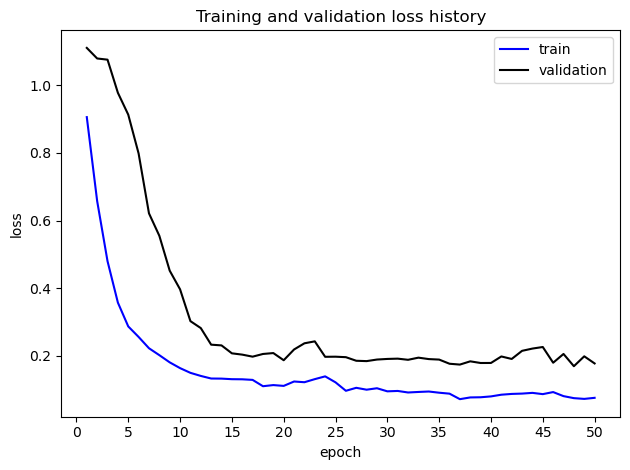

In [21]:
evaluate_history(history)


In [22]:
model.training


False

In [23]:
_tmp_y = []
_tmp_y_pred = []
for _batchdata_test in dataloader_test:
    _tmp_y.append(_batchdata_test.y)
    _tmp_y_pred.append(model(_batchdata_test.to(device)))


In [24]:
y_test_scaled = torch.cat(_tmp_y, dim=0)
y_pred_on_test_scaled = torch.cat(_tmp_y_pred, dim=0)


In [25]:
y_test = y_test_scaled * y_std + y_mean
y_pred_on_test = y_pred_on_test_scaled * y_std + y_mean


In [26]:
_tmp_y = []
_tmp_y_pred = []
for _batchdata_val in dataloader_val:
    _tmp_y.append(_batchdata_val.y)
    _tmp_y_pred.append(model(_batchdata_val.to(device)))


In [27]:
y_val_scaled = torch.cat(_tmp_y, dim=0)
y_pred_on_val_scaled = torch.cat(_tmp_y_pred, dim=0)


In [28]:
y_val = y_val_scaled * y_std + y_mean
y_pred_on_val = y_pred_on_val_scaled * y_std + y_mean


In [29]:
_tmp_y = []
_tmp_y_pred = []
for _batchdata_train in dataloader_train:
    _tmp_y.append(_batchdata_train.y)
    _tmp_y_pred.append(model(_batchdata_train.to(device)))


In [30]:
y_train_scaled = torch.cat(_tmp_y, dim=0)
y_pred_on_train_scaled = torch.cat(_tmp_y_pred, dim=0)


In [31]:
y_train = y_train_scaled * y_std + y_mean
y_pred_on_train = y_pred_on_train_scaled * y_std + y_mean


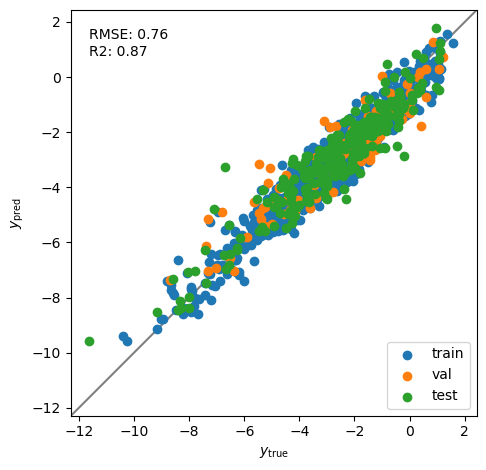

In [32]:
ax = yyplot(
    y_train.cpu().detach().numpy(),
    y_pred_on_train.cpu().detach().numpy(),
    y_val.cpu().detach().numpy(),
    y_pred_on_val.cpu().detach().numpy(),
    y_test.cpu().detach().numpy(),
    y_pred_on_test.cpu().detach().numpy(),
)
ax.figure.tight_layout()


In [33]:
# rdkit記述子を使ってRandomForestで予測した値と比較

dict_feat = dict()
for desc_name, desc_func in check_tqdm(Descriptors.descList, ipynb=True):
    dict_feat[desc_name] = [
        desc_func(Chem.MolFromSmiles(smi)) for smi in smiles
    ]
X = pd.DataFrame.from_dict(dict_feat)
X.head()


  0%|          | 0/211 [00:00<?, ?it/s]

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068,54.028,59.037114,24,...,0,0,0,0,0,0,0,0,0,0
1,4.597222,4.597222,1.652778,1.652778,0.273315,6.00,46.073,40.025,46.053098,20,...,0,0,0,0,0,0,0,0,0,0
2,9.000000,9.000000,0.833333,-0.833333,0.429883,6.25,60.052,56.020,60.021129,24,...,0,0,0,0,0,0,0,0,0,0
3,3.222222,3.222222,1.250000,1.250000,0.434794,24.00,71.123,62.051,71.073499,30,...,0,0,0,0,0,0,0,0,0,0
4,9.229167,9.229167,0.939815,-0.939815,0.256644,6.60,76.055,72.023,76.027277,30,...,0,0,0,0,0,0,0,0,0,1


In [34]:
X = X.loc[:, ~(X.isnull().any() | np.isinf(X).any())].astype(np.float32)
print(X.shape)
X.head()


(1290, 210)


,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,9.222222,9.222222,0.333333,-0.333333,0.401031,6.25,59.068001,54.028000,59.037113,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4.597222,4.597222,1.652778,1.652778,0.273315,6.00,46.073002,40.025002,46.053097,20.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,9.000000,9.000000,0.833333,-0.833333,0.429883,6.25,60.051998,56.020000,60.021130,24.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.222222,3.222222,1.250000,1.250000,0.434794,24.00,71.123001,62.050999,71.073502,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9.229167,9.229167,0.939815,-0.939815,0.256644,6.60,76.055000,72.023003,76.027275,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<Axes: xlabel='$y_\\mathrm{true}$', ylabel='$y_\\mathrm{pred}$'>

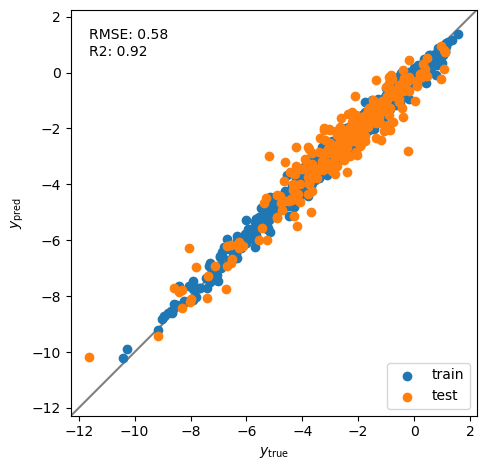

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X, np.array(y) * y_std + y_mean, test_size=0.2, random_state=seed
)
rf = RandomForestRegressor(random_state=seed, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred_on_test = rf.predict(X_test)
y_pred_on_train = rf.predict(X_train)
yyplot(y_train, y_pred_on_train, y_test, y_pred_on_test)
